In [1]:
import lib.evaluation as ev
import lib.plotting as plot
import lib.dataset as dt
import models

import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from importlib import reload

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [9]:
# Read small datasets
train = 'DATASET-TRAIN-80.csv'
val = 'DATASET-VALIDATION-10.csv'
test = 'DATASET-TEST-10.csv'

# train = 'OTRO-TRAIN-80.csv'
# val = 'OTRO-VALIDATION-10.csv'
# test = 'OTRO-TEST-10.csv'

In [10]:
# Prepare datasets
train_dataset, y_true_train = dt.create_dataset(train, num_classes=3, balanced=True, apply_data_augmentation=True, batch_size=4, prefetch_buffer=2, shuffle=True)
#train_dataset, y_true_train = dt.create_dataset(train, num_classes=3, apply_data_augmentation=True, batch_size=4, prefetch_buffer=2, shuffle=True)

val_dataset, y_true_val = dt.create_dataset(val, num_classes=3, prefetch_buffer=2)

test_dataset, y_true_test = dt.create_dataset(test, num_classes=3, prefetch_buffer=2)

In [11]:
#model = models.efficientNetB5.get_model(input_shape=(540,540,3), num_outputs=3)
model = models.inceptionV3.get_model(input_shape=(540,540,3), num_outputs=3)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


In [6]:
# Load weights if they were saved
save_path = 'saved_weights/efficientNetB5/model.h5'

if os.path.exists(save_path):
    model.load_weights(save_path)
    print('Model loaded')

In [12]:
# Small training
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
              metrics=['acc', 
                       tf.keras.metrics.AUC(summation_method='minoring', name='AUC')]) 
                       # 'minoring' applies left summation for increasing intervals and right summation for decreasing intervals

In [13]:
cbacks = [tf.keras.callbacks.ModelCheckpoint('saved_weights/inceptionV3/best_model.h5', 
                                             monitor='val_AUC',
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='max')]

history = model.fit(train_dataset.repeat(3), epochs=20, validation_data=val_dataset, callbacks=cbacks)

Epoch 1/20
9111/9111 [==============================] - 1144s 126ms/step - loss: 0.2483 - acc: 0.9873 - AUC: 0.9906 - val_loss: 34.9346 - val_acc: 0.1798 - val_AUC: 0.1061
Epoch 2/20
9111/9111 [==============================] - 1145s 126ms/step - loss: 0.2845 - acc: 0.9796 - AUC: 0.9845 - val_loss: 59.7742 - val_acc: 0.1798 - val_AUC: 0.1061
Epoch 3/20
9111/9111 [==============================] - 1151s 126ms/step - loss: 0.2887 - acc: 0.9761 - AUC: 0.9846 - val_loss: 45.6454 - val_acc: 0.1798 - val_AUC: 0.1061
Epoch 4/20
9111/9111 [==============================] - 1142s 125ms/step - loss: 0.2474 - acc: 0.9747 - AUC: 0.9853 - val_loss: 16.6350 - val_acc: 0.1798 - val_AUC: 0.1061
Epoch 5/20
9111/9111 [==============================] - 1149s 126ms/step - loss: 0.2237 - acc: 0.9763 - AUC: 0.9870 - val_loss: 21.4454 - val_acc: 0.1798 - val_AUC: 0.1061
Epoch 6/20
9111/9111 [==============================] - 1154s 127ms/step - loss: 0.2164 - acc: 0.9757 - AUC: 0.9874 - val_loss: 33.9451 - va

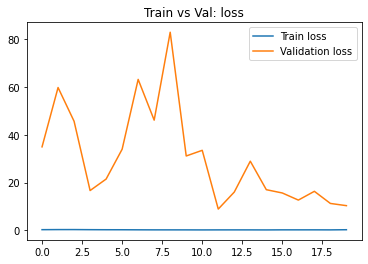

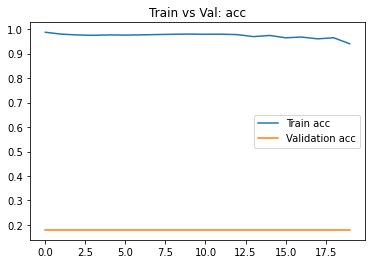

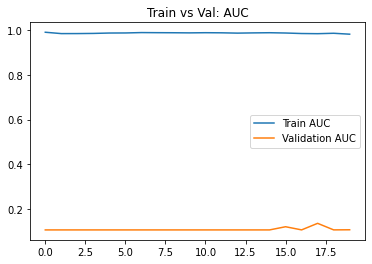

In [14]:
# Plot metrics - 0 1 234 balanced y SGD
plot.plot_metric(history, 'loss')
plot.plot_metric(history, 'acc')
plot.plot_metric(history, 'AUC')

In [26]:
model.save_weights('saved_weights/0_1_234_inception.h5')

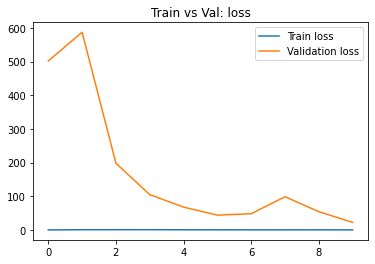

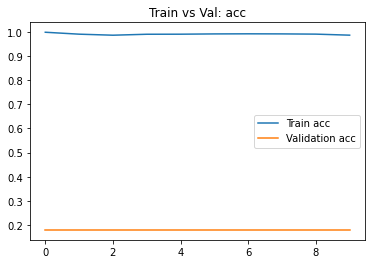

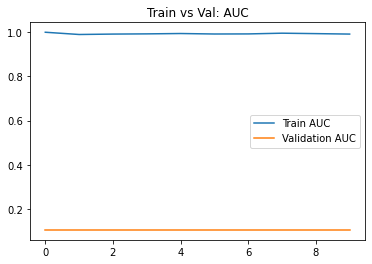

In [11]:
# Plot metrics
plot.plot_metric(history, 'loss')
plot.plot_metric(history, 'acc')
plot.plot_metric(history, 'AUC')

In [21]:
# Evaluating model
model.evaluate(test_dataset)

960/960 [==============================] - 30s 31ms/step - loss: 264.4051 - acc: 0.1937 - auc_1: 0.1156


[264.4050598144531, 0.19374999403953552, 0.11564452946186066]

In [15]:
# Validation predictions
y_pred_val = model.predict(val_dataset)

# Test predictions
y_pred_test = model.predict(test_dataset)

In [16]:
# Get ROC curves
reload(ev)

fpr_val, tpr_val, thr_val = ev.get_roc_curve(y_true_val[:,:-1], y_pred_val, num_thresholds=300, remove_under_ROC_points=True)

fpr_test, tpr_test, thr_test = ev.get_roc_curve(y_true_test[:,:-1], y_pred_test, num_thresholds=300, remove_under_ROC_points=True)

In [17]:
# Get closest points to 0,1 in validation ROCs
val_thr_closests = []
for i in range(len(fpr_val)):
    _, _, th = ev.find_closest_point_to_01(fpr_val[i], tpr_val[i], thr_val[i])
    val_thr_closests.append(th)
val_thr_closests = [tuple(val_thr_closests)]

In [18]:
# Operative points
reload(ev)
dr_levels, dr_classifications = ev.get_dr_levels_and_classifications_per_classes(y_true_val)

# Sensibility operative points 
operative_sens_points = [98, 95, 93, 90, 85]

results_val = ev.get_results_at_operative_points(fpr_val,
                                                 tpr_val,
                                                 thr_val,
                                                 y_pred_val,
                                                 dr_levels,
                                                 dr_classifications,
                                                 operative_sens_points,
                                                 operative_thresholds=val_thr_closests)

class_ = 0
results_val[class_].style.set_caption('Validation dataset - Class ' + str(class_) + ' - AUC: ' + str(round(ev.get_auc(fpr_val[class_], tpr_val[class_]), 4)))

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_0 (sample),Thresholds
0,98,98.000000,2.000000,2.000000,100.000000,0.020000
1,95,95.000000,5.000000,5.000000,100.000000,0.050000
2,93,93.000000,7.000000,7.000000,100.000000,0.070000
3,90,90.000000,10.000000,10.000000,100.000000,0.100000
4,85,85.000000,15.000000,15.000000,100.000000,0.150000
5,Closest point,50.000000,50.000000,50.000000,100.000000,0.500000


In [19]:
class_ = 1
results_val[class_].style.set_caption('Validation dataset - Class ' + str(class_) + ' - AUC: ' + str(round(ev.get_auc(fpr_val[class_], tpr_val[class_]), 4)))

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_1 (sample),Thresholds
0,98,98.000000,2.050000,2.000000,60.340000,0.000078
1,95,95.000000,5.120000,5.000000,61.490000,0.000195
2,93,93.000000,7.170000,7.000000,62.840000,0.000273
3,90,90.000000,10.240000,10.000000,63.030000,0.000391
4,85,85.000000,15.360000,15.000000,63.410000,0.000586
5,Closest point,14.370000,87.680000,85.630000,85.630000,0.003344


In [20]:
class_ = 2
results_val[class_].style.set_caption('Validation dataset - Class ' + str(class_) + ' - AUC: ' + str(round(ev.get_auc(fpr_val[class_], tpr_val[class_]), 4)))

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_2 (sample),FNR_3 (sample),FNR_4 (sample),Thresholds
0,98,98.000000,2.180000,2.000000,0.000000,0.000000,0.000000,0.993501
1,95,95.000000,5.430000,5.000000,0.100000,0.000000,0.000000,0.993787
2,93,93.000000,7.590000,7.000000,0.200000,0.000000,0.000000,0.993977
3,90,90.000000,10.840000,10.000000,0.300000,0.000000,0.000000,0.994262
4,85,85.000000,16.240000,15.000000,0.600000,0.000000,1.410000,0.994738
5,Closest point,64.840000,38.050000,35.160000,35.010000,35.510000,35.920000,0.996656


In [21]:
# Operative points
dr_levels, dr_classifications = ev.get_dr_levels_and_classifications_per_classes(y_true_test)

# Get thresholds from Validation ROCs
operative_thresholds = [res['Thresholds'] for res in results_val]
operative_thresholds = [e for e in zip(*operative_thresholds)]


results_test = ev.get_results_at_operative_points(fpr_test,
                                                 tpr_test,
                                                 thr_test,
                                                 y_pred_test,
                                                 dr_levels,
                                                 dr_classifications,
                                                 operative_thresholds=operative_thresholds)

class_ = 0
results_test[class_].style.set_caption('Test dataset - Class ' + str(class_) + ' - AUC: ' + str(round(ev.get_auc(fpr_test[class_], tpr_test[class_]), 4)))

,Sensibility,Specificity,False negative rate,FNR_0 (sample),Thresholds
0,98.000000,2.000000,2.000000,100.000000,0.020000
1,95.000000,5.000000,5.000000,100.000000,0.050000
2,93.000000,7.000000,7.000000,100.000000,0.070000
3,90.000000,10.000000,10.000000,100.000000,0.100000
4,85.000000,15.000000,15.000000,100.000000,0.150000
5,50.000000,50.000000,50.000000,100.000000,0.500000


In [22]:
class_ = 1
results_test[class_].style.set_caption('Test dataset - Class ' + str(class_) + ' - AUC: ' + str(round(ev.get_auc(fpr_test[class_], tpr_test[class_]), 4)))

,Sensibility,Specificity,False negative rate,FNR_1 (sample),Thresholds
0,99.990000,0.010000,0.010000,59.010000,0.000078
1,99.980000,0.020000,0.020000,61.980000,0.000195
2,99.970000,0.030000,0.030000,62.570000,0.000273
3,99.960000,0.040000,0.040000,62.770000,0.000391
4,99.940000,0.060000,0.060000,63.560000,0.000586
5,99.670000,0.330000,0.330000,89.500000,0.003344


In [23]:
class_ = 2
results_test[class_].style.set_caption('Test dataset - Class ' + str(class_) + ' - AUC: ' + str(round(ev.get_auc(fpr_test[class_], tpr_test[class_]), 4)))

,Sensibility,Specificity,False negative rate,FNR_2 (sample),FNR_3 (sample),FNR_4 (sample),Thresholds
0,97.980000,2.190000,2.020000,0.000000,0.000000,0.000000,0.993501
1,94.950000,5.420000,5.050000,0.090000,0.000000,0.700000,0.993787
2,92.930000,7.570000,7.070000,0.090000,0.000000,0.700000,0.993977
3,89.900000,10.800000,10.100000,0.090000,0.000000,1.400000,0.994262
4,84.850000,16.180000,15.150000,0.190000,0.000000,1.400000,0.994738
5,64.480000,37.880000,35.520000,35.070000,38.070000,35.660000,0.996656


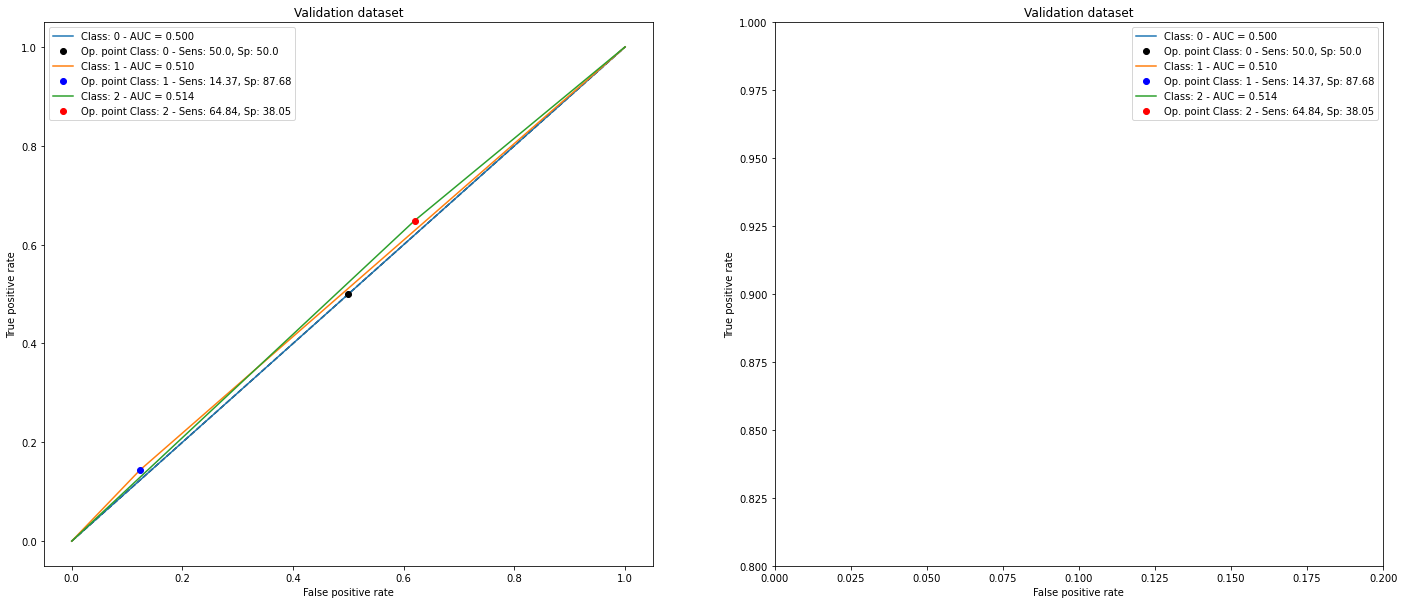

In [24]:
reload(plot)
plot.plot_roc_curve(fpr_val, tpr_val, thr_val, 'Validation dataset', list('012'), operative_threshold=None, grid=False, show_points=False)

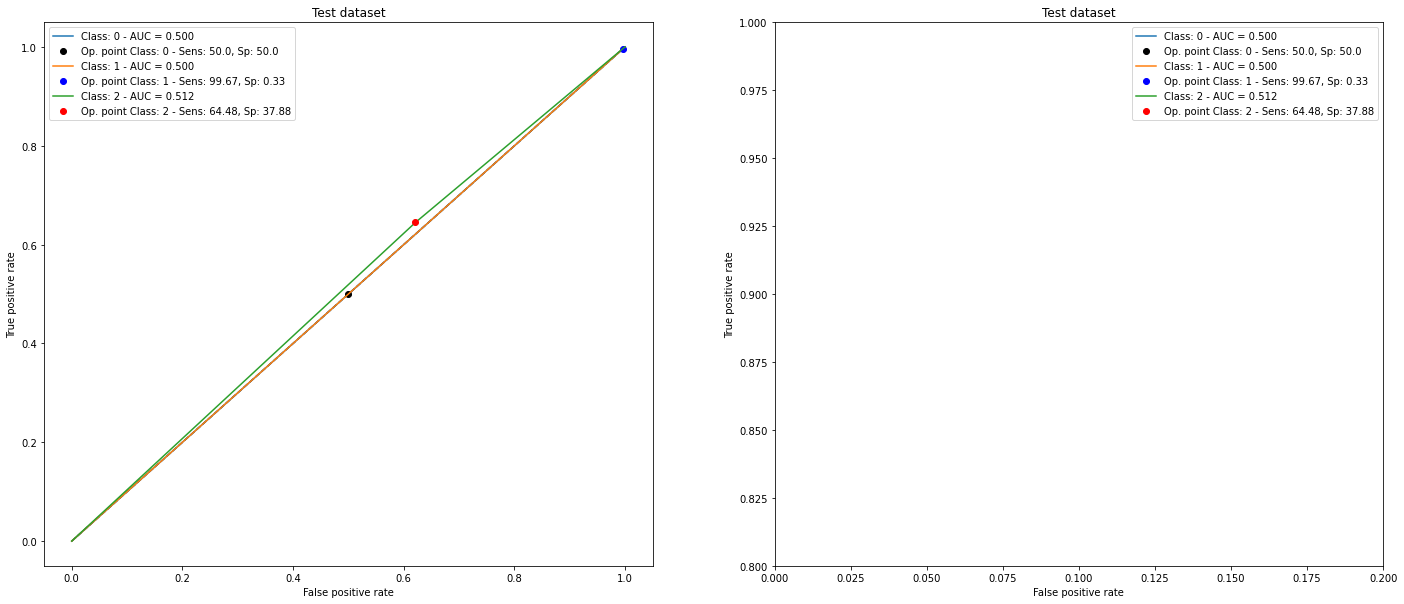

In [25]:
plot.plot_roc_curve(fpr_test, tpr_test, thr_test, 'Test dataset', list('012'), operative_threshold=operative_thresholds[-1], grid=False, show_points=False)

In [13]:
# Save model weights
model.save_weights(save_path)

In [69]:
model.save_weights('saved_weights/inceptionV3/model.h5')

In [70]:
model.load_weights('saved_weights/inceptionV3/best_model.h5')